https://github.com/Kabanosk/whisper-website
https://github.com/openai/whisper/discussions/264

In [51]:
# %%capture
# %pip install python-dotenv

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import yt_dlp
import unzip
from typing import List, Callable, Optional, Dict

# increase column width
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', None)

# Download Audio and Transcribe

In [4]:
VIDEO_URL = "https://youtu.be/DgTjSrrf6GQ"
AUDIO_FILE_NAME = "./data/audio/Lex_Podcast.mp3"
AUDIO_QUALITY = 5 # 0 best - 10 worst (default 5)
AUDIO_FORMAT = "mp3"
FFMPEG_LOCATION = "ffmpeg-master-latest-win64-gpl/bin"
SUBTITLE_LANGUAGE = "en.*"
TRANSCRIPT_FILE_NAME = "./data/transcript.txt"
SUBTITLE_FORMAT = "srt"

In [19]:
import wget
import os
import zipfile

FFMPEG_URL = 'https://github.com/yt-dlp/FFmpeg-Builds/releases/download/latest/ffmpeg-master-latest-win64-gpl.zip'
ZIP_PATH = './ffmpeg.zip'
EXTRACT_DIR = './'

if not os.path.exists(ZIP_PATH):
    print('Downloading ffmpeg...')
    wget.download(FFMPEG_URL, ZIP_PATH)

    print('Unzipping...') 
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)
    
    print('Removing zip file...')
    os.remove(ZIP_PATH)

else:
    print('Already downloaded.')

Unzipping...
Removing zip file...


In [ ]:
!yt-dlp -xv --ffmpeg-location ffmpeg-master-latest-win64-gpl/bin --audio-format mp3  -o data/audio/Lex_Podcast -- {"https://youtu.be/DEu24V8vfb8"}
#!yt-dlp -xv --ffmpeg-location {FFMPEG_LOCATION} --audio-format {AUDIO_FORMAT}  -o {AUDIO_FILE_NAME} -- {"https://youtu.be/DEu24V8vfb8"}

In [3]:
import openai
from dotenv import load_dotenv, find_dotenv
import os

_ = load_dotenv(find_dotenv())  # add .env to .gitignore
openai.api_key = os.getenv("OPENAI_API_KEY")


In [10]:
audio_file = open("data/audio/Lexicap.mp3", "rb")
transcript = openai.Audio.transcribe("whisper-1", audio_file, response_format=SUBTITLE_FORMAT)

In [9]:
# with open("langchain.srt", "w") as f:
#     f.write(transcript)

## Longer Inputs
By default, the Whisper API only supports files that are less than 25 MB. If you have an audio file that is longer than that, you will need to break it up into chunks of 25 MB's or less or used a compressed audio format. To get the best performance, we suggest that you avoid breaking the audio up mid-sentence as this may cause some context to be lost.

One way to handle this is to use the [PyDub open source Python package](https://github.com/jiaaro/pydub) to split the audio:

In [ ]:
from pydub import AudioSegment

song = AudioSegment.from_mp3("good_morning.mp3")

# PyDub handles time in milliseconds
ten_minutes = 10 * 60 * 1000

first_10_minutes = song[:ten_minutes]

first_10_minutes.export("good_morning_10.mp3", format="mp3")

### Prompting
* Check out [OpenAI](https://platform.openai.com/docs/guides/speech-to-text/prompting)

# Download Transcript

In [13]:
# Download the transcript with yt-dlp
!yt-dlp --write-auto-sub --skip-download --sub-format {SUBTITLE_FORMAT} --sub-lang {SUBTITLE_LANGUAGE} --output {TRANSCRIPT_FILE_NAME} -- {VIDEO_URL}

[youtube] Extracting URL: https://youtu.be/DgTjSrrf6GQ
[youtube] DgTjSrrf6GQ: Downloading webpage
[youtube] DgTjSrrf6GQ: Downloading android player API JSON
[info] DgTjSrrf6GQ: Downloading subtitles: en-orig, en, en-en-ehkg1hFWq8A
[info] DgTjSrrf6GQ: Downloading 1 format(s): 22
[info] Writing video subtitles to: transcript.txt.en-orig.vtt
[download] Destination: transcript.txt.en-orig.vtt

[download]    1.00KiB at  909.63KiB/s (00:00:00)
[download]    3.00KiB at    1.45MiB/s (00:00:00)
[download]    7.00KiB at    1.32MiB/s (00:00:00)
[download]   15.00KiB at    1.17MiB/s (00:00:00)
[download]   31.00KiB at  729.35KiB/s (00:00:00)
[download]   63.00KiB at  978.15KiB/s (00:00:00)
[download]  127.00KiB at    1.33MiB/s (00:00:00)
[download]  255.00KiB at    2.07MiB/s (00:00:00)
[download]  511.00KiB at    3.35MiB/s (00:00:00)
[download]  816.60KiB at    4.29MiB/s (00:00:00)
[download] 100% of  816.60KiB in 00:00:00 at 1.88MiB/s
[info] Writing video subtitles to: transcript.txt.en.vtt
[down

## Data Preparation
Let's change the name of the raw caption files:

In [79]:
# Get a clean list of podcast titles
import re 

def clean_titles(title):
    title = re.sub(r'\[(.*?)\]\((.*?)\)', r'\1', title)
    title = re.sub(r'\|.*?\d+', '', title)
    title = title.rstrip().replace(' ', '_').replace(':', '_').replace('&','and').lower()
    title = re.sub(r'[^a-zA-Z0-9_]', '', title)
    return title

with open('./data/Lexicap.md', 'r') as f:
    text = f.read()

titles = text.split('\n')
titles = [clean_titles(title) for title in titles if title != '']

In [ ]:
# Rename the transcript files
import os

TRANSCRIPT_PATH = "./data/transcripts/"
FILE_EXTENSION = '.vtt'

for org_filename, line_idx in zip(os.listdir(path=TRANSCRIPT_PATH), titles):
    if org_filename.endswith(FILE_EXTENSION):
        print(org_filename)
        # rename file 
        new_filename = f"{line_idx}{FILE_EXTENSION}"
        os.rename(f"{TRANSCRIPT_PATH}{org_filename}", f"{TRANSCRIPT_PATH}{new_filename}")

# Start
### Data Cleaning

In [5]:
TRANSCRIPT_PATH = "./data/transcripts/"
FILE_EXTENSION = '.vtt'

In [76]:
# Create new transcript file with timestamp and text
TRANSCRIPT_FILE_NAME = "45_michio_kaku__future_of_humans_aliens_space_travel_and_physics.vtt"
NEW_TRANSCRIPT_FILE_NAME = "45_michio_kaku__future_of_humans_aliens_space_travel_and_physics.csv"


with open(f"{TRANSCRIPT_PATH}{TRANSCRIPT_FILE_NAME}") as oldfile, open(f"{NEW_TRANSCRIPT_FILE_NAME}", 'w') as newfile:
    old_lines = oldfile.read().split('\n')
    clean_lines = [line for line in old_lines if line not in ['', 'WEBVTT']]

    for line_idx in range(0, len(clean_lines)-1, 2):
         timestamp = clean_lines[line_idx].split('-->')[0].strip()
         # Standardize timestamp format
         timestamp = "00:" + timestamp if len(timestamp.split(':')) < 3 else timestamp
         timestamp = "0" + timestamp if len(timestamp.split(':')[0]) < 2 else timestamp
         text = clean_lines[line_idx+1].rstrip()
         new_line = f"{timestamp};{text}\n"
         newfile.write(new_line)


In [92]:
transcript_df = pd.read_csv(f"{NEW_TRANSCRIPT_FILE_NAME}"
                            ,sep=';', 
                            header=None, names=['timestamp', 'text'],)
                            # parse_dates=['timestamp'], date_format='%H:%M:%S.%f')
# Convert timestamp to only time
# transcript_df['timestamp'] = transcript_df['timestamp'].dt.time

transcript_df.head(25)

,timestamp,text
0,00:00:00.000,The following is a conversation with Michio Kaku.
1,00:00:02.800,"He's a theoretical physicist, futurist,"
2,00:00:05.120,and professor at the City College of New York.
3,00:00:08.360,He's the author of many fascinating books
4,00:00:10.760,that explore the nature of our reality
5,00:00:12.840,and the future of our civilization.
6,00:00:15.520,"They include Einstein's Cosmos, Physics of the Impossible,"
7,00:00:19.200,"Future of the Mind, Parallel Worlds,"
8,00:00:21.600,"and his latest, The Future of Humanity,"
9,00:00:24.240,"Terraforming Mars Interstellar Travel,"


* Ideas
* Summarization of main topics in the audio
* Go to the mentions of the topics
* translation to arabic
* The app ask me questions about the text (for language learning) and create a discussion
* Click on named-entity, book in order to play at timestamp
* Webapp or Mobile app

* Since Whisper has not skipped the punctuations in the transcript, we can reconstruct full sentences, ensuring that each sentence is ended with a period `.`

In [93]:
# Recreate the dataframe with full sentences
full_transcript_df = pd.DataFrame(columns=transcript_df.columns)

for idx, timestamp, text in transcript_df.itertuples():
    while text[-1] != '.':
        idx += 1
        text += transcript_df.loc[idx]['text']
    full_transcript_df = pd.concat([full_transcript_df, pd.DataFrame({'timestamp': timestamp, 'text': text}, index=[0])], ignore_index=True)

# Remove any piece of text if it is included in previous text
not_part_of_previous = [True]
for i in range(1, len(full_transcript_df)):
    not_part_of_previous.append(full_transcript_df['text'][i] not in full_transcript_df['text'][i-1])
full_transcript_df = full_transcript_df[not_part_of_previous] 


# 1. NER
* Add column for persons, orginazations, books, companies, countries, places.

## Mentioned Books
Why identifying book titles can be difficult?
* The book may contain persons names which are not authors.
* The book titles are difficult to identify as such in general. For example "the Republic" might or might not be about the book, and if the only indication the model can use is the capitalization it's probably going to make some errors.

To be clear, I think it could work to some extent but it would probably make quite a lot of errors.

* On the other hand you could obtain a database of books, for instance from Wikipedia (there might be better resources), and you could use this in two ways:

1. Directly identify the books/authors in the documents by simple string matching. I would imagine that even if the coverage of the resource is not perfect, this method would easily catch a majority of occurrences.
2. In case the above method is not sufficient, it provides you with some good training data from which you could train a NER model in order collect titles which don't exist in the database. Note that there might be issues due to the unknown books being labelled as negative in the training data, so ideally you would have to go manually through the training data and annotate the remaining cases.

In [33]:
#%%capture
# %pip install -U spaCy
# %pip install 'spacy[transformers]'
#!python -m spacy download en_core_web_trf # download best-matching version of specific model

In [34]:
import spacy
# load a pipeline package by name and return nlp object
nlp = spacy.load("en_core_web_trf", disable=["tok2vec","parser"]) #disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer", "ner"]

# check processing pipeline components of nlp object
nlp.pipeline


[('transformer',
  <spacy_transformers.pipeline_component.Transformer at 0x1bd1e6f9f00>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x1bd1e6f9d80>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x1bd230f6d40>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x1bd230ba240>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x1bd22f3eb20>)]

In [35]:
# create a Doc by processing a string of text with the nlp object
doc = nlp("So I'm with Jared Diamond, you know, in the book Collapse, \
          where he points out studying the collapse of major civilizations, \
          that it often happens right after things appear to never have been better. Hmm.")


# iterate over tokens in a Doc
print("Entities: ", [e.text for e in doc.ents if e.label_ == 'WORK_OF_ART'])


Entities:  ['Collapse']


In [94]:
# Find book related sentences in the transcript
book_related_phrases = [
    "book", "books", "i read", 
    "everyone should read", "you should read", "he wrote a novel",
    "i recommend", "highly recommend", "you must read", 
    "shouldn't miss", "top books", "best books", 
    "favorite book", "my favorite books", "book you need to read",
    "books to read before", "essential books", "great book for",
    "worthy read", "book of the year", "award winning book"
]




def contains_book_phrase(text: str, search_list: List[str]) -> bool:
    """
    Check if a text contains any of a list of book-related phrases.

    :param text: The text to search within.
    :param search_list: A list of phrases to search for.
    :return: True if any phrase is found in the text, False otherwise.
    """
    return any(phrase in text.lower() for phrase in search_list)


full_transcript_df["is_book_related"] = full_transcript_df["text"].apply(contains_book_phrase, search_list=book_related_phrases)

In [95]:
def get_book_titles_candidates(text: str, pipeline: Callable[[str], 'Doc']) -> List[str]:
    """
    Extract potential book titles from a text using a given NLP model.

    :param text: The text to extract titles from.
    :param pipeline: The NLP model to use for text processing.
    :return: A list of potential book titles.
    """
    doc = nlp(text)
    book_titles_candidates = [entity.text for entity in doc.ents if entity.label_ == 'WORK_OF_ART']
    return book_titles_candidates


In [96]:
full_transcript_df.query("is_book_related == True")["text"].apply(get_book_titles_candidates,
                                                                  pipeline=nlp)

3                               []
182                             []
341                             []
478       [The Future of the Mind]
638                             []
859                             []
940                             []
954     [The Theory of Everything]
957                             []
1149          [Future of Humanity]
Name: text, dtype: object

In [97]:
# Add book candidates to the dataframe
full_transcript_df["book_candidates"] = full_transcript_df.apply(lambda x: get_book_titles_candidates(x["text"], pipeline=nlp) \
                                                                 if x["is_book_related"] else [], axis=1)

In [98]:
full_transcript_df.query("is_book_related == True")

,timestamp,text,is_book_related,book_candidates
3,00:00:08.360,He's the author of many fascinating books that explore the nature of our reality and the future of our civilization.,True,[]
182,00:08:30.920,"And Stephen Hawking, for example, even in his last book, even said that this is an argument against the existence of God.",True,[]
341,00:16:04.760,"If you read the book, the aliens did not have evil intentions toward homo sapiens.",True,[]
478,00:22:38.600,"I have a book, The Future of the Mind, where I detail some of these breakthroughs.",True,[The Future of the Mind]
638,00:29:54.080,"Our ancestors were lucky if they had one line, just one line in a church book, saying the date they were baptized and the date they died.",True,[]
859,00:40:07.240,"For Isidor Rabi, it was a book about the planets.",True,[]
940,00:44:06.200,"That desk had a book on it, which was opened.",True,[]
954,00:44:43.160,"And then over the years, I found out the guy had a name, Albert Einstein, and that book was The Theory of Everything.",True,[The Theory of Everything]
957,00:44:53.080,"Well, today I can read that book.",True,[]
1149,00:53:36.600,"And in my book, Future of Humanity, I even speculate beyond that, that by the end of this century, we'll probably have the first starships.",True,[Future of Humanity]


In [99]:
import requests

def get_book_info(title: str) -> Optional[Dict]:
    """
    Fetch book information from Google Books API.

    :param title: The title of the book to search for.
    :return: A dictionary containing book information if found, None otherwise.
    """
    try:
        response = requests.get(f"https://www.googleapis.com/books/v1/volumes?q={title}")

        # Raise an exception if the request was unsuccessful
        response.raise_for_status()

    except requests.HTTPError as http_err:
        print(f'HTTP error occurred: {http_err}')
        return None
    except Exception as err:
        print(f'Other error occurred: {err}')
        return None

    else:
        data = response.json()
        if 'items' in data:
            # Just return the first book found
            return data['items'][0]['volumeInfo']

print(get_book_info("Future of Humanity"))


get_book_info("Future of Humanity")


{'title': 'The Future of Humanity', 'subtitle': 'Terraforming Mars, Interstellar Travel, Immortality, and Our Destiny Beyond', 'authors': ['Michio Kaku'], 'publisher': 'Penguin UK', 'publishedDate': '2018-02-28', 'description': 'Human civilization is on the verge of spreading beyond Earth. More than a possibility, it is becoming a necessity: whether our hand is forced by climate change and resource depletion or whether future catastrophes compel us to abandon Earth, one day we will make our homes among the stars. World-renowned physicist and futurist Michio Kaku explores in rich, accessible detail how humanity might gradually develop a sustainable civilization in outer space. With his trademark storytelling verve, Kaku shows us how science fiction is becoming reality: mind-boggling developments in robotics, nanotechnology, and biotechnology could enable us to build habitable cities on Mars; nearby stars might be reached by microscopic spaceships sailing through space on laser beams; an

{'title': 'The Future of Humanity',
 'subtitle': 'Terraforming Mars, Interstellar Travel, Immortality, and Our Destiny Beyond',
 'authors': ['Michio Kaku'],
 'publisher': 'Penguin UK',
 'publishedDate': '2018-02-28',
 'description': 'Human civilization is on the verge of spreading beyond Earth. More than a possibility, it is becoming a necessity: whether our hand is forced by climate change and resource depletion or whether future catastrophes compel us to abandon Earth, one day we will make our homes among the stars. World-renowned physicist and futurist Michio Kaku explores in rich, accessible detail how humanity might gradually develop a sustainable civilization in outer space. With his trademark storytelling verve, Kaku shows us how science fiction is becoming reality: mind-boggling developments in robotics, nanotechnology, and biotechnology could enable us to build habitable cities on Mars; nearby stars might be reached by microscopic spaceships sailing through space on laser beam

## Identify Other Entities

In [19]:
# %%capture
# %pip install textacy

In [181]:
import textacy

entity_types = ['PERSON', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', 'WORK_OF_ART', 'LAW', 'DATE', 'TIME', 'MONEY']

from typing import List, Optional, Union
from spacy.tokens import Doc

def extract_entities(doc: Doc, 
                     include_types: Optional[Union[str, List[str]]] = None, 
                     sep: str = '_') -> List[str]:
    """
    Extract named entities from a document and return them as strings.

    :param doc: The document to extract entities from.
    :param include_types: The types of entities to include. If None, include all types.
    :param sep: The separator to use when joining lemmas of multi-token entities.
    :return: A list of named entities in the form 'lemma/label'.
    """
    ents = textacy.extract.entities(doc, 
                                    include_types=include_types, 
                                    exclude_types=None, 
                                    drop_determiners=True, 
                                    min_freq=1)
    
    return [sep.join([token.lemma_ for token in entity])+'/'+entity.label_ for entity in ents]



* When processing large volumes of text, it is recommended to use spaCys batch processing for a significant performance gain. The function `nlp.pipeline` takes an iterable of texts, processes them internally as batch, and yields a list fo processed Doc objects in the same order as the input data.
* To use `nlp.pipeline`, we first have to define a batch size. Then we can loop over the batches and call `nlp.pipe`. In the inner loop we extract the features from the processed doc and write the values back into the a list:

In [182]:
# Extract entities from the transcript
import numpy as np
from tqdm import tqdm

batch_size = 50
batches = np.ceil(len(full_transcript_df) / batch_size).astype(int)

named_entities = []

# loop over batches, step size is equal to batch size
for i in tqdm(range(0, len(full_transcript_df), batch_size), total=batches):
    docs = nlp.pipe(full_transcript_df['text'][i:i+batch_size])
    
    for doc in docs:
        named_entities.append(extract_entities(doc)) 

full_transcript_df['named_entities'] = named_entities 

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:49<00:00,  3.82s/it]


In [183]:
# Add columns for each entity type
for ent_type in entity_types:
    full_transcript_df[ent_type.lower()] = full_transcript_df["named_entities"].apply(lambda x: \
                                                                            [entity.split('/')[0] for entity in x if entity.split('/')[1] == ent_type])

In [184]:
full_transcript_df.head(2)

,timestamp,text,is_book_related,book_candidates,named_entities,person,org,gpe,loc,product,event,work_of_art,law,date,time,money,group
0,00:00:00.000,The following is a conversation with Michio Kaku.,False,None,[Michio_Kaku/PERSON],[Michio_Kaku],[],[],[],[],[],[],[],[],[],[],0
1,00:00:02.800,"He's a theoretical physicist, futurist, and professor at the City College of New York.",False,None,[City_College_of_New_York/ORG],[],[City_College_of_New_York],[],[],[],[],[],[],[],[],[],0


In [185]:
def contains_empty_list(df: pd.DataFrame, col_name: str) -> bool:
    """
    Check if a column in a DataFrame contains any empty lists.

    :param df: The DataFrame to check.
    :param col_name: The name of the column to check.
    :return: True if any empty list is found, False otherwise.
    """
    return df[col_name].apply(lambda x: x == []).any()


# Find columns with empty lists
cols_to_clean = [col for col in full_transcript_df.columns if contains_empty_list(full_transcript_df, col)]

# Remove empty lists 
for ent_type in cols_to_clean:
    full_transcript_df[ent_type] = full_transcript_df[ent_type].apply(lambda x: x if len(x) > 0 else None)

In [186]:
from collections import Counter 
import pandas as pd
from typing import Optional, Callable

def count_words(dataframe: pd.DataFrame, 
                column: str, 
                preprocess: Optional[Callable[[str], str]] = None, 
                min_frequency: int = 2) -> pd.DataFrame:
    """
    Count words in a specific column of a DataFrame.

    :param dataframe: The DataFrame to count words from.
    :param column: The column to count words in. Should be tokenized.
    :param preprocess: An optional function to preprocess the words before counting.
    :param min_frequency: The minimum frequency for a word to be included in the output.
    :return: A DataFrame sorted by word frequency, containing words and their frequencies.
    """
    word_counter = Counter()

    # If a preprocessing function is provided, apply it before counting words
    if preprocess:
        dataframe[column].map(lambda doc: word_counter.update(preprocess(doc)))
    else:
        dataframe[column].map(word_counter.update)

    # Convert Counter to DataFrame
    word_freq_df = pd.DataFrame.from_dict(word_counter, orient='index', columns=['freq'])
    
    # Filter words by minimum frequency
    word_freq_df = word_freq_df.query('freq >= @min_frequency')
    
    # Set index name for the dataframe
    word_freq_df.index.name = column

    # Sort DataFrame by frequency
    return word_freq_df.sort_values('freq', ascending=False)


In [187]:
# %%capture
# %pip install WordCloud

In [188]:
from wordcloud import WordCloud 
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

def generate_word_cloud(data: pd.DataFrame,
                        col_name: str, 
                        max_words: int = 200) -> None:
    """
    Generate a word cloud from word frequencies.

    :param data: A pandas DataFrame containing text data.
    :param col_name: The column name to count words from.
    :param max_words: The maximum number of words in the word cloud.
    """
    word_frequencies = count_words(data, col_name).freq

    # Convert pandas Series to Counter object
    word_frequencies = Counter(word_frequencies.fillna(0).to_dict())

    # Create wordcloud object
    word_cloud = WordCloud(width=800, height=400, 
                           background_color= "black", colormap="Paired", 
                           max_font_size=150, max_words=max_words)

    # Generate word cloud image from frequencies
    word_cloud.generate_from_frequencies(word_frequencies)

    # Display the cloud using matplotlib 
    plt.title(col_name.capitalize()) 
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")


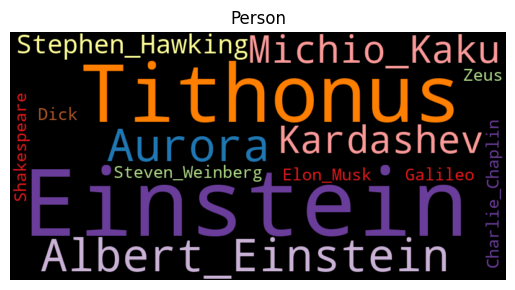

In [189]:
generate_word_cloud(full_transcript_df, 'person')

In [190]:
full_transcript_df.head(1)

,timestamp,text,is_book_related,book_candidates,named_entities,person,org,gpe,loc,product,event,work_of_art,law,date,time,money,group
0,00:00:00.000,The following is a conversation with Michio Kaku.,False,None,[Michio_Kaku/PERSON],[Michio_Kaku],None,None,None,None,None,None,None,None,None,None,0


# Q&A

I have to reconstruct the dataframe to get longer text to be more useful in vectore store.

In [ ]:
full_transcript_df['group'] = full_transcript_df.index // 10
new_df = full_transcript_df.groupby('group').agg({
    'timestamp': 'first',
    'text': ' '.join,
    'is_book_related': 'any',
    'book_candidates': 'sum',
    'named_entities': 'sum',
    
})
new_df.head()

In [143]:
qa_df = full_transcript_df.copy()
# drop all columns except text and timestamps
qa_df.drop(columns=[col for col in qa_df.columns if col not in ["timestamp", "text"]], inplace=True)
qa_df.head(6)

,timestamp,text
0,00:00:00.000,The following is a conversation with Michio Kaku.
1,00:00:02.800,"He's a theoretical physicist, futurist, and professor at the City College of New York."
3,00:00:08.360,He's the author of many fascinating books that explore the nature of our reality and the future of our civilization.
6,00:00:15.520,"They include Einstein's Cosmos, Physics of the Impossible, Future of the Mind, Parallel Worlds, and his latest, The Future of Humanity, Terraforming Mars Interstellar Travel, Immortality, and Our Destiny Beyond Earth."
11,00:00:29.960,I think it's beautiful and important when a scientific mind can fearlessly explore through conversation subjects just outside of our understanding.
15,00:00:40.200,"That, to me, is where artificial intelligence is today, just outside of our understanding, a place we have to reach for if we're to uncover the mysteries of the human mind and build human level and superhuman level AI systems that transform our world for the better."


In [237]:
qa_df['group'] = qa_df.index // 15
new_df = qa_df.groupby('group').agg({
    'timestamp': 'first',
    'text': ' '.join
})
new_df.head(6)

,timestamp,text
group,,
0,00:00:00.000,"The following is a conversation with Michio Kaku. He's a theoretical physicist, futurist, and professor at the City College of New York. He's the author of many fascinating books that explore the nature of our reality and the future of our civilization. They include Einstein's Cosmos, Physics of the Impossible, Future of the Mind, Parallel Worlds, and his latest, The Future of Humanity, Terraforming Mars Interstellar Travel, Immortality, and Our Destiny Beyond Earth. I think it's beautiful and important when a scientific mind can fearlessly explore through conversation subjects just outside of our understanding."
1,00:00:40.200,"That, to me, is where artificial intelligence is today, just outside of our understanding, a place we have to reach for if we're to uncover the mysteries of the human mind and build human level and superhuman level AI systems that transform our world for the better. This is the Artificial Intelligence Podcast. If you enjoy it, subscribe on YouTube, give it five stars on iTunes, support it on Patreon, or simply connect with me on Twitter at Lex Friedman, spelled F R I D M A N. And now, here's my conversation with Michio Kaku. You've mentioned that we just might make contact with aliens or at least hear from them within this century. Can you elaborate on your intuition behind that optimism? Well, this is pure speculation, of course."
2,00:01:28.120,"Of course. Given the fact that we've already identified 4,000 exoplanets orbiting other stars, and we have a census of the Milky Way galaxy for the first time, we know that on average, every single star, on average, has a planet going around it, and about one fifth or so of them have Earth sized planets going around them. So just do the math. We're talking about out of 100 billion stars in the Milky Way galaxy, we're talking about billions of potential Earth sized planets."
3,00:02:02.880,"And to believe that we're the only one is, I think, rather ridiculous, given the odds. And how many galaxies are there? Within sight of the Hubble Space Telescope, there are about 100 billion galaxies. So do the math. How many stars are there in the visible universe? 100 billion galaxies, times 100 billion stars per galaxy. We're talking about a number beyond human imagination. And to believe that we're the only ones, I think, is rather ridiculous. So you've talked about different types of, type zero, one, two, three, four, and five, even, of the Kardashev scale of the different kind of civilizations."
4,00:02:50.440,"What do you think it takes, if it is indeed a ridiculous notion that we're alone in the universe, what do you think it takes to reach out? First, to reach out through communication and connect. Well, first of all, we have to understand the level of sophistication of an alien life form if we make contact with them. I think in this century, we'll probably pick up signals, signals from an extraterrestrial civilization. We'll pick up there, I love Lucy, and there, leave it to Beaver. Just ordinary day to day transmissions that they emit."
5,00:03:25.600,"And the first thing we wanna do is to A, decipher their language, of course, but B, figure out at what level they are advanced on the Kardashev scale. I'm a physicist. We rank things by two parameters, energy and information. That's how we rank black holes. That's how we rank stars. That's how we rank civilizations in outer space. So a type one civilization is capable of harnessing planetary power. They control the weather, for example, earthquakes, volcanoes. They can modify the course of geological events, sort of like Flash Gordon or Buck Rogers. Type two would be stellar."


In [238]:
new_df.to_csv('data\michio_kaku_transcript.csv', index=False)

In [239]:
# %%capture
# %pip install langchain

In [240]:
# %%capture
# %pip install docarray

In [241]:
# %%capture
# %pip install tiktoken

In [242]:
import openai
from dotenv import load_dotenv, find_dotenv
import os

_ = load_dotenv(find_dotenv())  # add .env to .gitignore
openai.api_key = os.getenv("OPENAI_API_KEY")

In [243]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import CSVLoader 
from langchain.vectorstores import DocArrayInMemorySearch
from IPython.display import display, Markdown

In [244]:
# Initilize csv loader with a path to a csv file
file = 'data\michio_kaku_transcript.csv'
loader = CSVLoader(file_path=file, encoding='utf-8')

In [245]:
# Import an index to create a vectorstore
from langchain.indexes import VectorstoreIndexCreator

In [246]:
# Initialize a vectorstore index by passing in a vectorstore class and a list of document loaders
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch
).from_loaders([loader])

In [248]:
# Ask a question
query ="Who was the guest in this episode?"
query = "Which books are mentioned in this episode? find them all. find the time stamps for each book."
# query = "According to the video Why is fusion so difficult to put on the Earth?"

# Create a response
response = index.query(query)
response


" The Theory of Everything (00:44:35.520), a book about the planets (00:39:57.720), and Stephen Hawking's last book (00:08:24.860)."

Good enough to go in more details :)

In [206]:
# Load documents from the doument loader
docs = loader.load()

Each document represents one row of the CSV file. Every row is converted into a key/value pair and outputted to a new line in the document’s ``page_content``.

In [122]:
docs[0]

Document(lc_kwargs={'page_content': 'timestamp: 00:00:00.000\ntext: The following is a conversation with Michio Kaku.', 'metadata': {'source': ' The following is a conversation with Michio Kaku.', 'row': 0}}, page_content='timestamp: 00:00:00.000\ntext: The following is a conversation with Michio Kaku.', metadata={'source': ' The following is a conversation with Michio Kaku.', 'row': 0})

In [104]:
docs[0]

Document(lc_kwargs={'page_content': "timestamps: 00:00.000\ntext: The following is a conversation with Michio Kaku.\nis_book_related: False\nbook_candidates: \nnamed_entities: ['Michio_Kaku/PERSON']\nperson: ['Michio_Kaku']\norg: \ngpe: \nloc: \nproduct: \nevent: \nwork_of_art: \nlaw: \ndate: \ntime: \nmoney: ", 'metadata': {'source': ' The following is a conversation with Michio Kaku.', 'row': 0}}, page_content="timestamps: 00:00.000\ntext: The following is a conversation with Michio Kaku.\nis_book_related: False\nbook_candidates: \nnamed_entities: ['Michio_Kaku/PERSON']\nperson: ['Michio_Kaku']\norg: \ngpe: \nloc: \nproduct: \nevent: \nwork_of_art: \nlaw: \ndate: \ntime: \nmoney: ", metadata={'source': ' The following is a conversation with Michio Kaku.', 'row': 0})

In [125]:
from langchain.embeddings import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()

In [126]:
embed = embeddings.embed_query("Hi my name is Ahmad")

In [207]:
# Create a vectorstore from documents and embeddings
db = DocArrayInMemorySearch.from_documents(
    docs,      # list of documents
    embeddings # embedding object
)

In [208]:
query = "which books are mentioned in the text?"
#query ="Who was the guest in this episode?"

similar_docs = db.similarity_search(query)

In [209]:
list(similar_docs)

[Document(lc_kwargs={'page_content': "timestamp: 00:11:32.240\ntext: Well, I don't know.  I don't profess to understand the great secrets of the universe.\nis_book_related: False\nbook_candidates: 0\nnamed_entities: 0", 'metadata': {'source': 'data\\michio_kaku_transcript.csv', 'row': 24}}, page_content="timestamp: 00:11:32.240\ntext: Well, I don't know.  I don't profess to understand the great secrets of the universe.\nis_book_related: False\nbook_candidates: 0\nnamed_entities: 0", metadata={'source': 'data\\michio_kaku_transcript.csv', 'row': 24}),
 Document(lc_kwargs={'page_content': "timestamp: 00:44:06.200\ntext: That desk had a book on it, which was opened.  And the caption said more or less, this is the unfinished manuscript from the greatest scientists of our time.  So I said to myself, well, why couldn't he finish it? What's so hard that you can't finish it if you're a great scientist? It's a homework problem, right? You go home, you solve it, or you ask your mom, why couldn't